# Package loading and basic configurations

In [ ]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import matplotlib.pyplot as plt
import scipy
import math  
from scipy.misc import derivative
from scipy import interpolate
import datetime
import time
import requests as req,json
import numpy as np
import pandas as pd
import geopandas as gpd
from envirocar import TrackAPI, DownloadClient, BboxSelector, TimeSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

# Querying enviroCar Tracks

The following cell queries tracks from the enviroCar API. It defines a bbox for the area of Münster (Germany) and requests 50 tracks in the time interval. 

In [ ]:
bbox = BboxSelector([
    7.603312, # min_x
    51.952343, # min_y
    7.65083, # max_x 
    51.974045,  # max_y 
])


# issue a query
track_df = track_api.get_tracks(bbox=bbox,  num_results=50) # requesting 50 tracks inside the bbox


## Define parameters of the car

In [56]:
#Define General Parameters

P_air = 1.2   # Air mass density "kg per m³" 
P_idle = 2    # Idle power "kW"
Cw = 0.3      # Air drag cofficient 
H_g = 8.8     # Calorific value gasoline "kWh/l"
H_d = 9.9     # Calorific value diesel "kWh/l"
g = 9.81      # Gravitational acceleration "m/s²"
efc = 0.30    # efficiency constant value from Literature 0.25 - 0.35

#Define Car parameters
class Car:
    def __init__(self,m=1500,A=2,Cw=0.3):
        self.m = m
        self.A = A
        self.Cw = Cw

##  Define specific paramerer by class (Volkswagen)
volks = Car(1570,2.179,0.32)
##generalcar = car
car = Car()


## Different functions (distance, gradient, speed equation, fuel consumption, engine power)

In [57]:
#Define the distance equation based on "Jiménez-Meza, A., Arámburo-Lizárraga, J., & de la Fuente, E. (2013). Framework for estimating travel time, distance, speed, and street segment level of service (los), based on GPS data. Procedia Technology, 7, 61-70."

def distance(lon1,lon2,lat1,lat2): 
    b = 69.1 * (lat2 - lat1)
    e = 69.1 * (lon2 - lon1) * np.cos(lat1/57.3)
    d = math.sqrt((b ** 2) + (e ** 2)) * 1609.344
    return d

#define gradient equation
def gradient(height,distance):
    return height/distance


## Define engine power (KW) equation
def engine_power(car,Cr,gradient,speed,acceleration):
    if speed > 0:
        power =speed*(0.5*car.Cw*car.A*P_air*pow(speed,2) #driving resistance
                      +car.m*g*Cr*np.cos(gradient) #rolling resistence
                      +car.m*g*np.sin(gradient) # climbing resistance
                      +car.m*+acceleration) # inertial resistance
        return [power/1000, power/speed]
    else:
        resistance =(0.5*car.Cw*car.A*P_air*pow(speed,2) #driving resistance
                      +car.m*g*Cr*np.cos(gradient) #rolling resistence
                      +car.m*g*np.sin(gradient) # climbing resistance
                      +car.m*+acceleration) # inertial resistance
        return [P_idle, resistance]
    
# interpolate to find efficiency values based on driving resistance
def interpolation(x):
    A = [-2000, 2000]
    B = [0.1, 0.4]
    f = interpolate.interp1d(A, B)
    efficiency = f(x)
    return efficiency

## Fuel consumption ewuation
def fuel_consumption(eng_pow, H_fuel, efc):
    consumption = eng_pow / (H_fuel * efc)
    return consumption

# Request elevation values from an open source (opentopodata.org)
url = 'https://api.opentopodata.org/v1/eudem25m?locations='

# put 100 points in each request
def generate_parms(s,e):
    lats= list(one_track[s:e]['geometry'].y)
    lngs = list(one_track[s:e]['geometry'].x)
    track_coords = [c for c in zip(lats, lngs)]
    format_str=list(map(lambda x : str(x[0])+','+str(x[1])+'|', track_coords)) 
    concat_str = ''.join(format_str)
    return concat_str

# send the request
def request(link):
    elevation = req.request('GET',link)
    results = elevation.json()['results']
    status =elevation.json()['status']
    if status=='OK':
        h = list(map(lambda x : x['elevation'], results))
    else:
        h= None
    return h

## Estimate fuel consumption/Co2 emissions for tracks in dataframe

In [58]:
## Make for loop to iterate over the routes and calculate fuel consumption/Co2 emissions to a group of routes together

tracks = pd.DataFrame(columns=track_df.columns)
for i in range (10,30):
    
    # Get the first track
    one_track_id = track_df['track.id'].unique()[i]
    one_track = track_df[track_df['track.id'] == one_track_id]
    
    # estimate the len of data
    batch = [int(len(one_track)/100),len(one_track)%100]
    elevation=[]
    
    # get elevation values
    for i in range(batch[0]+1):
        #create requeest 100 parameter 
        s = i*100
        e = (i+1)*100
        if i<batch[0]+1:
            --e 
        else:
            e= e+batch[1]

        parms= generate_parms(s,e)
        access= url+parms
        part = request(access)
        if part==None:
            part=[np.nan]*(e+1-s)    
        elevation.extend(part)
        time.sleep(1)
    one_track['elevation']=elevation
    temp=one_track[one_track['elevation'].isnull()==True]
    if len(temp)> 0:
        for i in temp.index:
            one_track.loc[i,'elevation']=one_track.loc[i,'GPS Altitude.value']
    
    
    # claculate the gradient
    for i in one_track.index:
        if (i == len(one_track)-1):
            break
        lat1= one_track.loc[i,'geometry'].y
        lat2= one_track.loc[i+1,'geometry'].y
        lon1= one_track.loc[i,'geometry'].x
        lon2= one_track.loc[i+1,'geometry'].x
        heightdiff = one_track.loc[i+1,'elevation'] - one_track.loc[i,'elevation']
        one_track.loc[i+1,'seg_distance']= distance(lon1,lon2,lat1,lat2)
        grade = gradient(heightdiff,one_track.loc[i+1,'seg_distance'])
        one_track.loc[i,'gradient']= grade
    
    ## Add interval time
    j = 5
    for i in one_track.index:
        one_track.loc[i, 'time_interval'] = j
        j = j+5
        
    # Convert the speed unit to m/s
    for i in one_track.index:
        one_track.loc[i, 'speed'] = one_track.loc[i, 'GPS Speed.value'] / 3.6
    
    # calculate acceleration
    time_interval = np.array(one_track['time_interval'])
    for i in one_track.index:
        if (i == len(one_track)-1):
            break
        else:
            one_track.loc[i, 'Acceleration'] = (one_track.loc[i+1, 'speed'] - one_track.loc[i, 'speed'])/5
    
    ## Calculates Engine Power for general car
    for i in one_track.index:
        ep = engine_power(car,0.02,one_track.gradient[i],one_track.speed[i],one_track.Acceleration[i])
        if ep[0] < 0:
            one_track.loc[i, 'engine_power'] = P_idle
            one_track.loc[i, 'driving_resistance'] = ep[1]
        else:
            one_track.loc[i, 'engine_power'] = ep[0]
            one_track.loc[i, 'driving_resistance'] = ep[1]
    
    #Calculates Engine Power for specific car (Volks)
    for i in one_track.index:
        ep = engine_power(volks,0.02,one_track.gradient[i],one_track.speed[i],one_track.Acceleration[i])
        if ep[0] < 0:
            one_track.loc[i, 'eng_pw_volks'] = P_idle
            one_track.loc[i, 'driving_resistance'] = ep[1]
        else:
            one_track.loc[i, 'eng_pw_volks'] = ep[0]
            one_track.loc[i, 'driving_resistance_volks'] = ep[1]
    
    # calculate the efficiency based on the driving resistance         
    for i in one_track.index:
        res = one_track.loc[i, 'driving_resistance']
        res_volks = one_track.loc[i, 'driving_resistance_volks']
        if (res >= 2000 or res <= -2000):
            one_track.loc[i,'efficiency'] = 0.3
        else:
            one_track.loc[i, 'efficiency'] = interpolation(res)
        if (res_volks >= 2000 or res_volks <= -2000):
            one_track.loc[i,'efficiency_volks'] = 0.3
        else:
            one_track.loc[i, 'efficiency_volks'] = interpolation(res_volks)            
            
    ## Fuel consumption/CO2 emissions for General car (gasoline)
    for i in one_track.index:
        car_cons = fuel_consumption(one_track.engine_power[i],H_g, one_track.loc[i,'efficiency']) 
        one_track.loc[i, 'Consumption_Gasoline'] = car_cons   ## liters / hour
        one_track.loc[i, 'CO2_Gasoline'] = car_cons * 2.39      ## kg Co2 / hour

    
    ## Fuel consumption/CO2 emissions for for Volks (diesel)
    for i in one_track.index:
        volks_cons = fuel_consumption(one_track.eng_pw_volks[i],H_d, one_track.loc[i, 'efficiency_volks']) 
        one_track.loc[i, 'Consumption_volks_diesel'] = volks_cons    ## liters / hour
        one_track.loc[i, 'CO2_volks_diesel'] = volks_cons * 2.69     ## kg Co2 / hour
    
    tracks = pd.concat([tracks, one_track])

## Filter the data

In [59]:
## filter attributes for all tracks 
all_tracks = tracks[['time', 'speed', 'time_interval', 'Acceleration', 'gradient', 'engine_power', 'eng_pw_volks', 'Consumption.value', 'Consumption_Gasoline','CO2_Gasoline','Consumption_volks_diesel','CO2_volks_diesel','geometry' ]]

## filter attributes for one track
one_track_id = tracks['track.id'].unique()[11]
track = tracks[tracks['track.id'] == one_track_id]

one_track = track[['time', 'speed', 'time_interval', 'Acceleration', 'elevation','gradient', 'engine_power','driving_resistance','efficiency', 'eng_pw_volks', 'Consumption.value','Consumption_Gasoline','CO2_Gasoline','Consumption_volks_diesel','CO2_volks_diesel']]
one_track

,time,speed,time_interval,Acceleration,elevation,gradient,engine_power,driving_resistance,efficiency,eng_pw_volks,Consumption.value,Consumption_Gasoline,CO2_Gasoline,Consumption_volks_diesel,CO2_volks_diesel
0,2019-12-29T12:11:19,3.802064,5.0,0.148187,-0.312093,0.006931,2.371581,623.761473,0.296782,2.484539,2.201733,0.908066,2.170278,0.839314,2.257755
1,2019-12-29T12:11:25,4.543000,10.0,-0.180077,-0.209130,0.001434,0.239459,52.709425,0.253953,0.254531,3.186081,0.107151,0.256090,0.101141,0.272069
2,2019-12-29T12:11:30,3.642615,15.0,-0.702525,-0.176606,0.010470,2.000000,-628.149130,0.202889,2.000000,1.890531,1.120184,2.677239,NaN,NaN
3,2019-12-29T12:11:35,0.129990,20.0,-0.025998,-0.065007,-0.012105,0.010032,77.172731,0.255788,0.010500,1.771329,0.004457,0.010651,0.004142,0.011142
4,2019-12-29T12:11:40,0.000000,25.0,0.000000,-0.066134,-0.020266,2.000000,-3.949228,0.249704,2.000000,1.833710,0.910169,2.175305,0.809084,2.176436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,2019-12-29T14:36:43,0.000000,8615.0,0.047910,62.675255,0.000137,2.000000,368.178855,0.277613,2.000000,1.685962,0.818666,1.956612,0.724341,1.948477
1723,2019-12-29T14:36:48,0.239552,8620.0,-0.047910,62.675323,-0.007448,0.027033,112.848897,0.258464,0.028295,2.153064,0.011885,0.028406,0.011041,0.029701
1724,2019-12-29T14:36:53,0.000000,8625.0,0.000000,62.666435,-0.000309,2.000000,289.754600,0.271732,2.000000,1.690632,0.836387,1.998965,0.740691,1.992458
1725,2019-12-29T14:36:58,0.000000,8630.0,0.000000,62.666382,0.003368,2.000000,343.854834,0.275789,2.000000,1.793028,0.824082,1.969555,0.729334,1.961909


## Comprasion between estimated fuel consumption & OBD values 

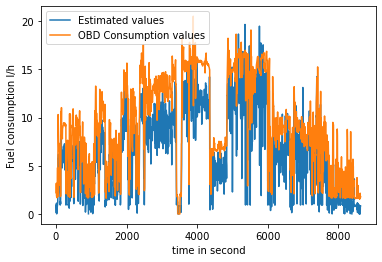

In [60]:
f, axarr = plt.subplots(1)
x = time_interval = np.array(one_track['time_interval'])
y1 = np.array(one_track['Consumption_Gasoline'])
y2 = np.array(one_track['Consumption.value'])
one = axarr.plot(x,y1, label="Estimated values")
two = axarr.plot(x,y2, label="OBD Consumption values" )
axarr.set_xlabel('time in second')
axarr.set_ylabel('Fuel consumption l/h')
axarr.legend()
filename = "E:\\Munster\\Floating Car\\Group Assignmnet 2\\fcda1.png"
plt.savefig(filename, format= 'png' )
plt.show()


### The relationship between consumption and speed/acceleration

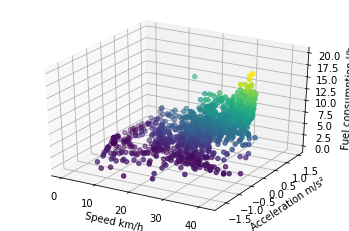

In [61]:
#set axes
ax = plt.axes(projection='3d')
zdata = np.array(one_track['Consumption_Gasoline'])
xdata = np.array(one_track['speed']) 
ydata = np.array(one_track['Acceleration'])

#set labels
ax.set_xlabel('Speed km/h')
ax.set_ylabel('Acceleration m/s²')
ax.set_zlabel('Fuel consumption l/h')
ax.scatter3D(xdata, ydata, zdata, c=zdata);
filename = "E:\\Munster\\Floating Car\\Group Assignmnet 2\\fcda2.png"
plt.savefig(filename, format= 'png' )

## Plot different variables for one track

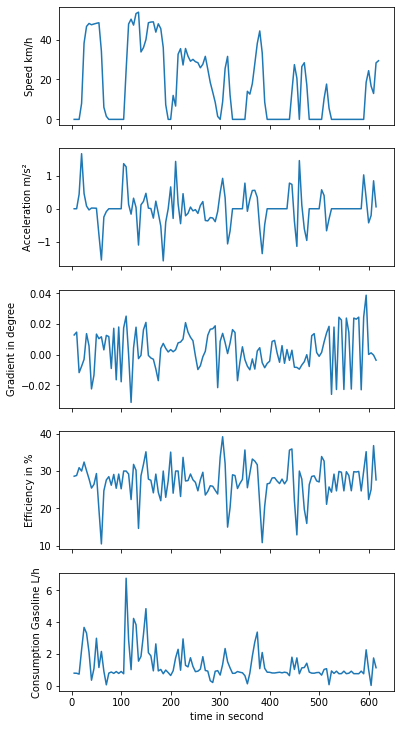

In [62]:
## select on track
one_track_id = tracks['track.id'].unique()[5]
track = tracks[tracks['track.id'] == one_track_id]

one_track = track[['time', 'speed', 'time_interval', 'Acceleration', 'elevation','gradient', 'engine_power','driving_resistance','efficiency', 'eng_pw_volks', 'Consumption.value','Consumption_Gasoline','CO2_Gasoline','Consumption_volks_diesel','CO2_volks_diesel']]
one_track

f, axarr = plt.subplots(5, sharex=True)
figsize=(8, 6)
time_interval = np.array(one_track['time_interval'])
speed = np.array(one_track['speed']) / 0.27777
acceleration = np.array(one_track['Acceleration'])
Consumption_Gasoline = np.array(one_track['Consumption_Gasoline'])
gradient = np.array(one_track['gradient'])
efficiency = np.array(one_track['efficiency']) * 100



axarr[0].plot(time_interval , speed)
axarr[1].plot(time_interval , acceleration)
axarr[2].plot(time_interval , gradient)
axarr[3].plot(time_interval , efficiency)
axarr[4].plot(time_interval , Consumption_Gasoline)



axarr[4].set_xlabel('time in second')
axarr[0].set_ylabel('Speed km/h')
axarr[1].set_ylabel('Acceleration m/s²')
axarr[2].set_ylabel('Gradient in degree')
axarr[3].set_ylabel('Efficiency in %')
axarr[4].set_ylabel('Consumption Gasoline L/h')


plt.subplots_adjust(top=2.5)


## The most efficient driving behaviour on a route

In [63]:
one_track_id = tracks['track.id'].unique()[7]
track = tracks[tracks['track.id'] == one_track_id]
test_track = track[['track.length','time','time_interval', 'speed', 'Acceleration', 'elevation','gradient',]]


In [64]:
test_track

,track.length,time,time_interval,speed,Acceleration,elevation,gradient
0,2.341898,2020-01-05T15:52:01,5.0,6.121902,0.059594,60.231903,0.006452
1,2.341898,2020-01-05T15:52:06,10.0,6.419874,-0.154965,60.448933,0.004566
2,2.341898,2020-01-05T15:52:11,15.0,5.645050,-0.038176,60.586002,0.003892
3,2.341898,2020-01-05T15:52:16,20.0,5.454171,-0.085098,60.652843,0.004496
4,2.341898,2020-01-05T15:52:21,25.0,5.028682,-1.005736,60.794601,0.004423
...,...,...,...,...,...,...,...
91,2.341898,2020-01-05T15:59:41,460.0,0.000000,0.043027,58.911308,0.012399
92,2.341898,2020-01-05T15:59:46,465.0,0.215135,-0.043027,58.920212,0.012953
93,2.341898,2020-01-05T15:59:51,470.0,0.000000,0.000000,58.947453,NaN
94,2.341898,2020-01-05T15:59:56,475.0,0.000000,0.000000,58.947453,-0.001709


### Driving behaviour on the route in the city 

In the following section, differnt speed profile (constant speed) tested to check the fuel instantinous fuel consumption on the route at different speed, and the accuumulated consumption on a route with the time.

In [65]:
# constant speed value

speed = [10, 20, 30, 40, 50]
acceleration = [0]
columns = ['consumption_10', 'consumption_20', 'consumption_30', 'consumption_40', 'consumption_50']
accumulate_consumption = ['accumulate_10', 'accumulate_20', 'accumulate_30', 'accumulate_40', 'accumulate_50']
cumulated = 0
cumulated_fuel = []
for x in range(0,5):
    test_track.insert(2,columns[x], True)
    for i in test_track.index:
        ep = engine_power(car,0.02,test_track.gradient[i],speed[x]/3.6,acceleration[0])
        if ep[0] < 0:
            test_track.loc[i, 'engine_power'] = P_idle
            test_track.loc[i, 'driving_resistance'] = ep[1]
        else:
            test_track.loc[i, 'engine_power'] = ep[0]
            test_track.loc[i, 'driving_resistance'] = ep[1]
    for i in test_track.index:
        res = test_track.loc[i, 'driving_resistance']
        if (res >= 2000 or res <= -2000):
            test_track.loc[i,'efficiency'] = 0.3
            
        else:
            test_track.loc[i, 'efficiency'] = interpolation(res)
                   
    ## Instantaneous/Cumulated Fuel consumption
    for i in test_track.index:
        car_cons = fuel_consumption(test_track.engine_power[i],H_g, test_track.loc[i,'efficiency']) 
        test_track.loc[i, columns[x]] = car_cons
        acc_cons = (car_cons / 3600)*5
        value = acc_cons
        
        if value >=0:
            cumulated += value
        
        test_track.loc[i, accumulate_consumption[x]] = cumulated
    ## Cumulated Fuel Consumption
    cumulated_fuel.append(cumulated)
    cumulated = 0


In [66]:
test_track

,track.length,time,consumption_50,consumption_40,consumption_30,consumption_20,consumption_10,time_interval,speed,Acceleration,elevation,gradient,engine_power,driving_resistance,efficiency,accumulate_10,accumulate_20,accumulate_30,accumulate_40,accumulate_50
0,2.341898,2020-01-05T15:52:01,2.54544,1.93814,1.39563,0.90257,0.44288,5.0,6.121902,0.059594,60.231903,0.006452,6.370532,458.678313,0.284401,0.000615,0.001254,0.001938,0.002692,0.003535
1,2.341898,2020-01-05T15:52:06,2.4091,1.82761,1.31187,0.846313,0.414625,10.0,6.419874,-0.154965,60.448933,0.004566,5.985211,430.935203,0.282320,0.001191,0.002429,0.003760,0.005230,0.006881
2,2.341898,2020-01-05T15:52:11,2.35986,1.78769,1.28162,0.82599,0.404417,15.0,5.645050,-0.038176,60.586002,0.003892,5.847421,421.014279,0.281576,0.001753,0.003576,0.005540,0.007713,0.010159
3,2.341898,2020-01-05T15:52:16,2.40398,1.82345,1.30872,0.844197,0.413562,20.0,5.454171,-0.085098,60.652843,0.004496,5.970835,429.900125,0.282243,0.002327,0.004749,0.007358,0.010246,0.013498
4,2.341898,2020-01-05T15:52:21,2.39863,1.81912,1.30544,0.841991,0.412454,25.0,5.028682,-1.005736,60.794601,0.004423,5.955846,428.820944,0.282162,0.002900,0.005918,0.009171,0.012772,0.016829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2.341898,2020-01-05T15:59:41,2.96264,2.27629,1.65186,1.07465,0.529299,460.0,0.000000,0.043027,58.911308,0.012399,7.585771,546.175522,0.290963,0.040848,0.083903,0.131337,0.185257,0.247672
92,2.341898,2020-01-05T15:59:46,3.0005,2.30697,1.6751,1.09026,0.537138,465.0,0.215135,-0.043027,58.920212,0.012953,7.698825,554.315383,0.291574,0.041594,0.085417,0.133664,0.188461,0.251839
93,2.341898,2020-01-05T15:59:51,NaN,NaN,NaN,NaN,NaN,470.0,0.000000,0.000000,58.947453,NaN,NaN,NaN,NaN,0.041594,0.085417,0.133664,0.188461,0.251839
94,2.341898,2020-01-05T15:59:56,1.94051,1.44764,1.02387,0.652851,0.317452,475.0,0.000000,0.000000,58.947453,-0.001709,4.702768,338.599311,0.275395,0.042035,0.086324,0.135086,0.190472,0.254534


### Plot Instantaneous Fuel consumption at different speed profile

The following graph shows how the fuel consumption affected by change the speed, it is obvious that decrasing the speed in the city from 50km/h to 30km/h would help save fuel and reduce CO2 emissios. 

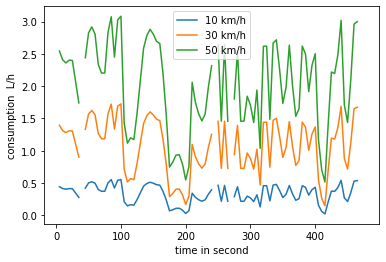

In [67]:
f, axarr = plt.subplots(1)

x = np.array(test_track['time_interval'])
consumption_10 = np.array(test_track['consumption_10']) 
consumption_20 = np.array(test_track['consumption_20'])
consumption_30 = np.array(test_track['consumption_30'])
consumption_40 = np.array(test_track['consumption_40'])
consumption_50 = np.array(test_track['consumption_50']) 

one = axarr.plot(x,consumption_10, label="10 km/h")
two = axarr.plot(x,consumption_30, label="30 km/h")
three = axarr.plot(x,consumption_50, label="50 km/h")
axarr.set_xlabel('time in second')
axarr.set_ylabel('consumption  L/h')
axarr.legend()
plt.show()

### Plot accumulated Fuel consumption against speed profile

The next plot shows the behavouir of accumulated fuel consumption against speed, you can notice that increasing the speed on the route leads to increase the accumulated fuel consumption on the route.


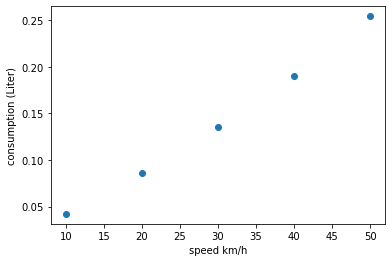

In [68]:

f, axarr = plt.subplots(1)
x = np.array(speed)
y = np.array(cumulated_fuel) 
one = axarr.scatter(x,y, label="Accumulated Fuel consumption")
axarr.set_xlabel('speed km/h')
axarr.set_ylabel('consumption (Liter)')
plt.show()

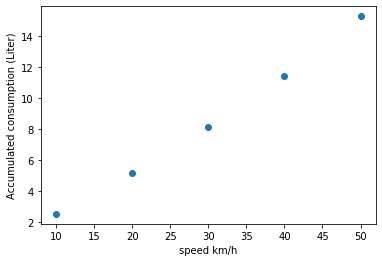

In [69]:
# the accumuated fuel consumtion on the road If 60 cars traverse on the road at the same speed, 
f, axarr = plt.subplots(1)
x = np.array(speed)
y = np.array(cumulated_fuel) * 60
one = axarr.scatter(x,y, label="Accumulated Fuel consumption")
axarr.set_xlabel('speed km/h')
axarr.set_ylabel('Accumulated consumption (Liter)')
plt.show()

## Plot accumulate Fuel consumption on a route against specific time

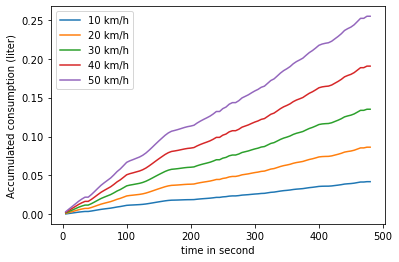

In [70]:
# Accumulate fuel consumption for one car

f, axarr = plt.subplots(1)

x = np.array(test_track['time_interval'])
consumption_10 = np.array(test_track['accumulate_10'])
consumption_20 = np.array(test_track['accumulate_20'])
consumption_30 = np.array(test_track['accumulate_30'])
consumption_40 = np.array(test_track['accumulate_40'])
consumption_50 = np.array(test_track['accumulate_50'])

one = axarr.plot(x,consumption_10, label="10 km/h")
two = axarr.plot(x,consumption_20, label="20 km/h" )
three = axarr.plot(x,consumption_30, label="30 km/h")
four = axarr.plot(x,consumption_40, label="40 km/h")
five = axarr.plot(x,consumption_50, label="50 km/h")
axarr.set_xlabel('time in second')
axarr.set_ylabel('Accumulated consumption (liter)')
axarr.legend()
plt.show()

## The most efficient route

The following map shows different routes, visualized depending on the fuel consumption to let the user now which is the most efficient route. 

In [72]:
import plotly.express as px
tracks['lat'] = tracks['geometry'].apply(lambda coord: coord.y)
tracks['lng'] = tracks['geometry'].apply(lambda coord: coord.x)
tracks.dropna()
fig = px.scatter_mapbox(tracks, lat="lat", lon="lng", color="Consumption_Gasoline")
fig.update_layout(mapbox_style="open-street-map")
fig.show()

## The fastest/shortest route


The following network build based on OSM for the same study area, then used the nwteork to find the fastest route between two points (based on time) if the speed value is the maximun speed allowed on the route.

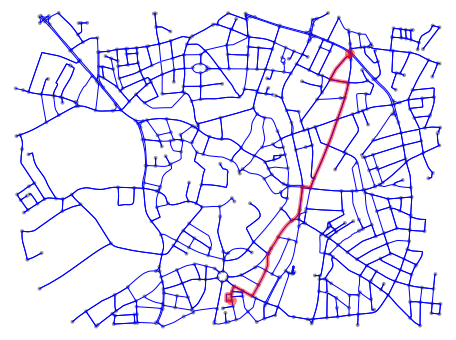

In [11]:
import osmnx as ox
import networkx as nx

G = ox.graph_from_bbox(51.974045, 51.952343, 7.65083, 7.603312, network_type='drive')
orig = list(G)[1]
dest = list(G)[-1]

# add the missing values
hwy_speeds = {'residential': 35,
              'secondary': 50,
              'tertiary': 60}

G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

# find the fastest/shortest route depend on time/length
route1 = nx.shortest_path(G, orig, dest, weight='time')
route = nx.shortest_path(G, orig, dest, weight='length')
fig, ax = ox.plot_graph_route(G, route1, edge_color= 'blue')

## The most efficient route & The fastest route

The following cells used to match the routes with OSM, and assign the estimated CO2 emissions on the road to the OSM segment, then build a network to compare between the fastest route and the most efficient route between two points.

One limitation of this method, the routes not cover the whole OSM that leads to assign (0) CO2 emissions for edges not cover by the routes, that affect the network ad find the most efficient route.  

In [191]:
## extract the OSM network and assign the CO2 emmisions

nodes, streets = ox.graph_to_gdfs(G)

ox.plot_graph_folium(G, graph_map=None, popup_attribute=None, tiles='cartodbpositron', zoom=1, fit_bounds=True, edge_color='#333333', edge_width=1, edge_opacity=1)
streets1 = streets
allstreets = pd.DataFrame(columns=streets.columns)
l = [0] * len(streets)
for i in range (0,20):
    one_track_id = tracks['track.id'].unique()[i]
    one_track = tracks[tracks['track.id'] == one_track_id]
    for i in one_track.index:
        
        lat= one_track.loc[i,'geometry'].y
        lng= one_track.loc[i,'geometry'].x
        u1,v1,key = (ox.get_nearest_edge(G, (lat, lng)))
        index = streets1[(streets1.u ==u1) & (streets1.v ==v1)].index
        num = index.array[0]
        value = one_track.loc[i,'CO2_Gasoline']
        if value>= 0:
            l[num]+= value
     

### Graph of OSM network 

In [211]:
graph2 = ox.graph_from_gdfs(nodes, streets1)
edge_colors = ox.plot.get_edge_colors_by_attr(graph2, 'co2', num_bins=5, cmap='viridis', start=0, stop=1, na_color='none')

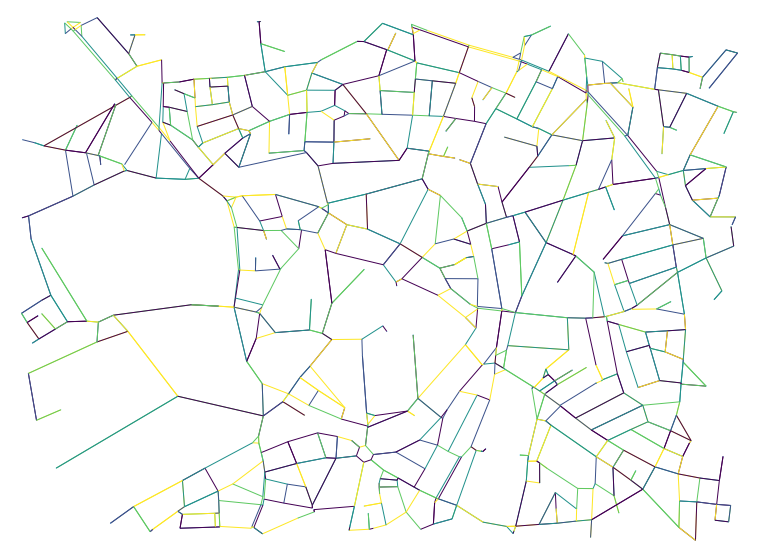

In [212]:
fig, ax = ox.plot_graph(ox.project_graph(graph2), fig_height=10, node_size=1, edge_color=edge_colors, dpi=600)


### The most efficient route / less Co2 emissions

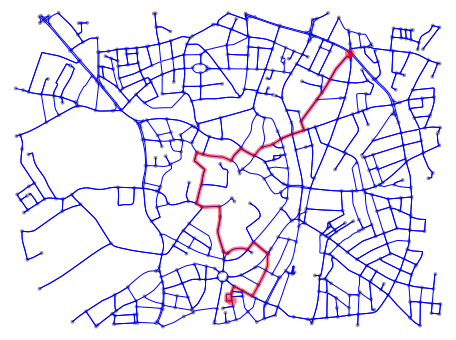

In [213]:
orig = list(graph2)[1]
dest = list(graph2)[-1]
route2 = nx.shortest_path(graph2, orig, dest, weight='co2')

fig, ax = ox.plot_graph_route(graph2, route2, edge_color= 'blue')

### The fastest route / less time

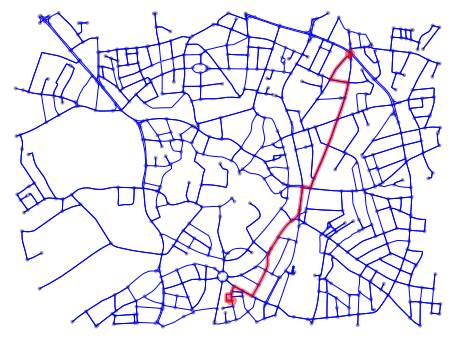

In [182]:
orig = list(graph2)[1]
dest = list(graph2)[-1]
route1 = nx.shortest_path(graph2, orig, dest, weight='time')

fig, ax = ox.plot_graph_route(graph2, route1, edge_color= 'blue')